# Exploratory Data Analysis

This notebook is for exploratory data analysis of the TMBD Box Office Prediction dataset.

In [1]:
import os
import sys
import subprocess
from zipfile import ZipFile
import pandas as pd
import matplotlib.pyplot as plt

# This boilerplate gives notebook access to the project's Python modules.
# **WARNING:** This snippet may need to be modified if the notebook is moved.
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Load the data
To do this step, you need a Kaggle API token.

Download the Kaggle API token from your "My Account" page of Kaggle.com.

Place the downloaded token `kaggle.json`  in the directory `~/.kaggle`. This is where the `kaggle` execuable looks for the API token.

### TODO
- once this is working, put it in the module `tmbd.make_dataset`
- write a `Makefile` with targets implemented by these functions to manage dependencies between steps
  - e.g., prevent redownloading the dataset if not necessary

In [6]:
from tmbd.make_dataset import RAW_DATA_DIR, FIG_DIR

def download_data():
    """Download and extract the Kaggle data."""
    RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)
    subprocess.run(["kaggle", "competitions", "download",
                    "tmdb-box-office-prediction", "-p", 
                    str(RAW_DATA_DIR)],
                  check=True)
    
    for zp in RAW_DATA_DIR.glob("*.zip"):
        ZipFile(zp).extractall(path=RAW_DATA_DIR)

def load_test():
    """Read the test.csv file into a Pandas dataframe."""
    return pd.read_csv(RAW_DATA_DIR.joinpath("test.csv"))

def load_train():
    """Read the train.csv file into a Pandas dataframe."""
    return pd.read_csv(RAW_DATA_DIR.joinpath("train.csv"), index_col=0)

FIG_DIR.mkdir(exist_ok=True)

In [10]:
train = load_train()
display(train.dtypes)
display(train.describe())

belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
Keywords                  object
cast                      object
crew                      object
revenue                    int64
dtype: object

,budget,popularity,runtime,revenue
count,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,2.253133e+07,8.463274,107.856571,6.672585e+07
std,3.702609e+07,12.104000,22.086434,1.375323e+08
min,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3.800000e+08,294.337037,338.000000,1.519558e+09


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


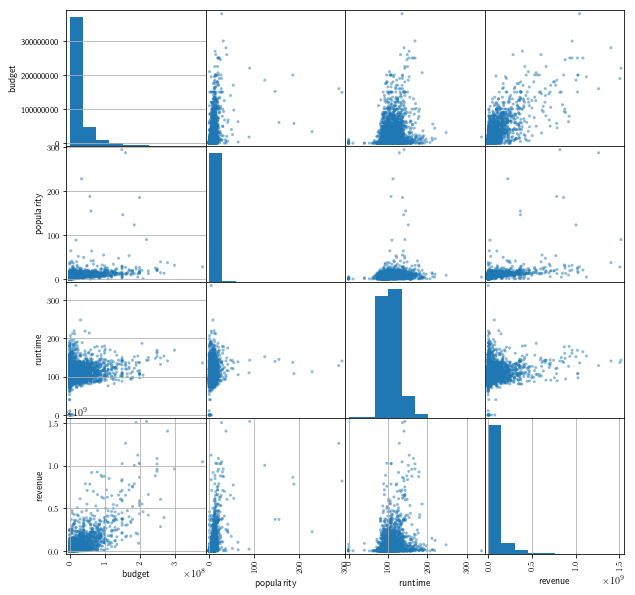

In [11]:
fig, ax = plt.subplots(figsize = (10,10))
scatter_matrix = pd.plotting.scatter_matrix(train,ax = ax)
fig.savefig(FIG_DIR.joinpath("scatter_matrix.png"))

In [16]:
train["original_language"].plot.bar()

TypeError: Empty 'DataFrame': no numeric data to plot